In [1]:
from deepweeds.datasets import deep_weeds
from pathlib import Path
from keras import saving
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from itertools import chain
import numpy as np

2025-02-28 13:21:54.921817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740748914.984901   66663 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740748915.001732   66663 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 13:21:55.143552: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
split = 'test'
data_path = Path('../data/images')
model_path = Path('../outputs/2025-02-20/14-04-37/MeNet.keras')
class_names = [
    "rubber_vine",
    "negative",
    "parthenium",
    "chinee_apple",
    "prickly_acacia",
    "snake_weed",
    "parkinsonia",
    "siam_weed",
    "lantana",
]
train_loader, val_loader = deep_weeds.get_train_val_dataloader(data_path / split)
model = saving.load_model(model_path)

Using 3152 files for training.
Using 350 files for validation.


I0000 00:00:1740748922.890385   66663 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:0c:00.0, compute capability: 8.9


In [3]:
x_data, y_data = [],[]
for x,y in chain(train_loader, val_loader):
    x_data.append(x.numpy())
    y_data.append(y.numpy())

data_df = pd.DataFrame({'X': x_data, 'y': y_data})

2025-02-28 13:22:06.204046: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-28 13:22:06.336679: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
data_df['label'] = data_df.y.apply(lambda idx: class_names[idx])

In [5]:
data_df.head()

,X,y,label
0,"[[[54, 53, 58], [46, 49, 54], [63, 74, 78], [2...",1,negative
1,"[[[69, 82, 72], [10, 26, 15], [24, 40, 29], [2...",1,negative
2,"[[[169, 162, 170], [33, 26, 33], [41, 30, 38],...",1,negative
3,"[[[209, 235, 190], [230, 255, 214], [239, 255,...",5,snake_weed
4,"[[[226, 250, 236], [195, 217, 204], [233, 253,...",1,negative


In [6]:
from typing import Generator


def get_batch(data_df: pd.DataFrame) -> Generator[tf.Tensor, None, None]:
    batch_size = 1024
    for i in range(0, len(data_df), batch_size):
        batch_df = data_df.iloc[i:i+batch_size]
        yield tf.convert_to_tensor(np.stack(batch_df.X, axis=0))

In [7]:
preds = []
for batch in get_batch(data_df):
    preds.append(model.predict(batch))

I0000 00:00:1740748931.280059   66797 service.cc:148] XLA service 0x7f2c98006fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740748931.280268   66797 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-02-28 13:22:11.298950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740748931.416912   66797 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-28 13:22:11.970439: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_607', 48 bytes spill stores, 48 bytes spill loads

2025-02-28 13:22:12.015766: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_607', 184 byt

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

I0000 00:00:1740748934.030851   66797 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

2025-02-28 13:22:16.907970: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_607', 48 bytes spill stores, 48 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step


In [8]:
data_df['y_logits'] = list(chain(*preds))

In [9]:
activations_matrix = np.stack(data_df.y_logits.values)  
data_df['y_pred'] = np.argmax(activations_matrix, axis=1)
data_df['label_pred'] = data_df.y_pred.apply(lambda idx: class_names[idx])

In [10]:
data_df

,X,y,label,y_logits,y_pred,label_pred
0,"[[[54, 53, 58], [46, 49, 54], [63, 74, 78], [2...",1,negative,"[7.15256e-07, 0.00604248, 0.984375, 0.00034904...",2,parthenium
1,"[[[69, 82, 72], [10, 26, 15], [24, 40, 29], [2...",1,negative,"[1.49608e-05, 0.0480957, 0.800781, 0.010437, 0...",2,parthenium
2,"[[[169, 162, 170], [33, 26, 33], [41, 30, 38],...",1,negative,"[5.91278e-05, 0.863281, 0.00189972, 0.045166, ...",1,negative
3,"[[[209, 235, 190], [230, 255, 214], [239, 255,...",5,snake_weed,"[0.000541687, 0.0296631, 0.0114136, 0.808594, ...",3,chinee_apple
4,"[[[226, 250, 236], [195, 217, 204], [233, 253,...",1,negative,"[6.34193e-05, 0.291016, 0.664062, 0.00619507, ...",2,parthenium
...,...,...,...,...,...,...
3497,"[[[153, 178, 218], [166, 190, 226], [118, 141,...",1,negative,"[5.88894e-05, 0.326172, 0.00524902, 0.00111389...",7,siam_weed
3498,"[[[85, 60, 79], [91, 66, 85], [167, 142, 163],...",1,negative,"[0.000417709, 0.855469, 0.100098, 0.0177002, 1...",1,negative
3499,"[[[230, 209, 214], [15, 0, 2], [50, 37, 44], [...",1,negative,"[0.000164986, 0.388672, 0.105957, 0.00326538, ...",6,parkinsonia
3500,"[[[248, 255, 255], [248, 253, 255], [254, 255,...",1,negative,"[0.0456543, 0.691406, 0.00915527, 0.129883, 0....",1,negative


In [11]:
print(classification_report(data_df.y, data_df.y_pred, target_names=class_names))

                precision    recall  f1-score   support

   rubber_vine       0.96      0.85      0.90       202
      negative       0.95      0.91      0.93      1821
    parthenium       0.76      0.97      0.85       204
  chinee_apple       0.71      0.86      0.78       225
prickly_acacia       0.87      0.89      0.88       213
    snake_weed       0.90      0.62      0.73       203
   parkinsonia       0.90      0.98      0.94       206
     siam_weed       0.82      0.96      0.89       215
       lantana       0.90      0.86      0.88       213

      accuracy                           0.89      3502
     macro avg       0.86      0.88      0.86      3502
  weighted avg       0.90      0.89      0.89      3502



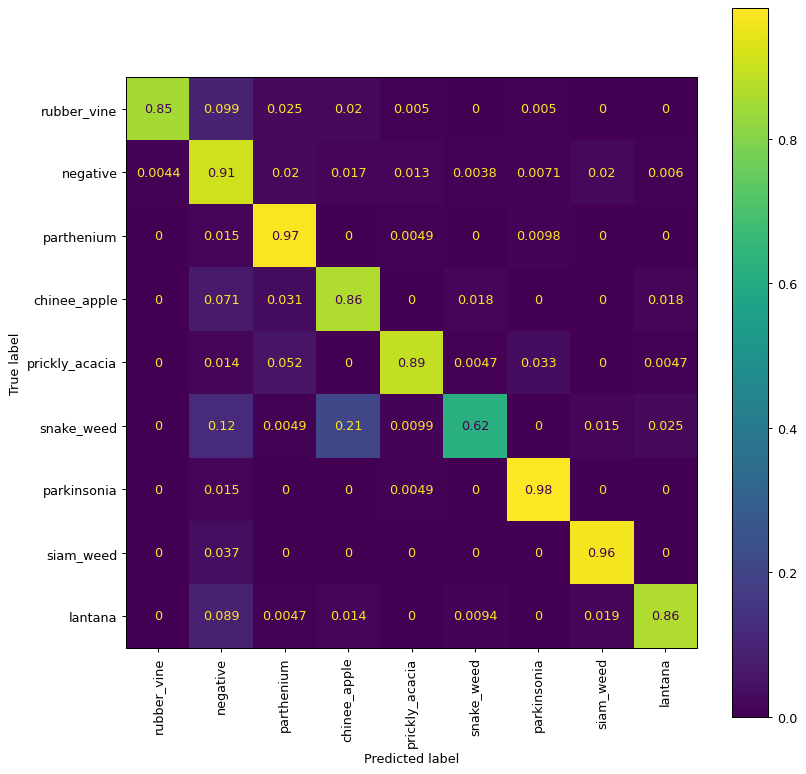

In [12]:
cmatrix = confusion_matrix(data_df.y, data_df.y_pred, normalize='true')
ax = plt.gca()
ax.figure.set_size_inches(10,10)
ax.figure.set_dpi(92)
# ax.tick_params(axis='x', rotation=45)
cmd = ConfusionMatrixDisplay(cmatrix, display_labels=class_names)
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.show()